In [1]:
%%time
import os
import numpy as np
import torch
from torch.utils.data import DataLoader, Dataset, Subset
from sklearn.model_selection import train_test_split, KFold
from torchvision import transforms
from PIL import Image
from transformers import SegformerForSemanticSegmentation, SegformerConfig, SegformerImageProcessor
import tkinter as tk
from tkinter import filedialog
import tensorflow as tf
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, precision_score, recall_score, f1_score, accuracy_score
from transformers import SamModel, SamProcessor
from torch import nn
from scipy.ndimage import label, find_objects
from sklearn.model_selection import StratifiedKFold
from datetime import datetime

# DataSet
class SplashDataSet_train_val_0501(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images_dir = os.path.join(self.root_dir, "images")
        self.masks_dir = os.path.join(self.root_dir, "annotations")
        # get filenames
        self.images_list = sorted(os.listdir(self.images_dir))
        self.masks_list = sorted(os.listdir(self.masks_dir))
        assert len(self.images_list) == len(self.masks_list), "Number of images and annotations should be the same."

        # transform image to 1024*1024
        self.transform = transforms.Compose([
            transforms.Resize((1024, 1024)),
            transforms.ToTensor(),  # This will scale pixel values to [0, 1]
        ])
    def __len__(self):
        return len(self.images_list)

    def __getitem__(self, idx):
        # get image and annotation file
        img_path = os.path.join(self.images_dir, self.images_list[idx])
        mask_path = os.path.join(self.masks_dir, self.masks_list[idx])
        
        image = Image.open(img_path)
        mask = Image.open(mask_path)
        
        image = self.transform(image)
        mask = self.transform(mask)

        # Convert mask to binary 0 and 1
        mask = (mask > 0).to(torch.int)
        mask = mask[0, None, :, :]
        
        return image, mask

    def get_time_category(self, filename):
        # my filenames' format is 2024-04-09-03-00-11.png
        time_str = filename.split('-')[3:5]
        time_obj = datetime.strptime('-'.join(time_str), '%H-%M')
        hour = time_obj.hour
        if hour < 8:
            return 'morning'
        elif 8 <= hour <= 16:
            return 'day'
        else:
            return 'evening'

# criterion
def criterion(outputs, labels):
    return torch.nn.functional.cross_entropy(outputs, labels.squeeze(1).long())

def KD_criterion(student_outputs, teacher_outputs, labels, teacher_ratio, temperature):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    #print("student_outputs size = ", student_outputs.size())
    # print("student_outputs = ", student_outputs["out"])
    #print("teacher_outputs size = ", teacher_outputs.size())
    # print("teacher_outputs = ", teacher_outputs)
    #print("ground truth size = ", labels.size())
    
    # Calculate Cross Entropy
    original_loss = torch.nn.functional.cross_entropy(student_outputs, labels.squeeze(1).long())

    # Calculate Distillation Loss
    soft_teacher_outputs = torch.softmax(teacher_outputs[0, 0, :, :] / temperature, dim=1)
    soft_student_outputs = torch.log_softmax(student_outputs[0, 0, :, :] / temperature, dim=1)
    distillation_loss = nn.KLDivLoss()(soft_student_outputs.to(device), soft_teacher_outputs.to(device))

    # total loss
    total_loss = (1-teacher_ratio)*original_loss + teacher_ratio*distillation_loss
    return total_loss

# evaluate
def evaluate(model, val_loader, device):
    model.eval()
    model.to(device)
    total_loss = 0.0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)

            outputs = model(image)

            loss = criterion(outputs['out'], mask)
            total_loss += loss.item()
    avg_loss = total_loss / len(val_loader)
    print(f"Average validation loss: {avg_loss}")
    return avg_loss

# train every epoch
def train_one_epoch(student_model, teacher_model, teacher_image_processor, data_loader, teacher_ratio, temperature, optimizer, device, pbar):
    student_model.to(device)
    student_model.train()
    teacher_model.to(device)
    teacher_model.eval()
    training_loss = []
    for idx, (image, mask) in enumerate(data_loader):
        #bbox = [[[get_bounding_box(np.array(mask))]]]
        bbox, point = get_bounding_box_and_center(np.array(mask))
        #print("[train_one_epoch] bbox = ", bbox)
        #print("[train_one_epoch] point = ", point)
        image, mask = image.to(device), mask.to(device)
        # image size = torch.Size([1, 3, 1024, 1024])start_step
        # mask size = torch.Size([1, 1, 1024, 1024])

        optimizer.zero_grad()
        # output for student model ----------------------------------------------------------
        student_outputs = student_model(image)
        # outputs size = torch.Size([1, 2, 1024, 1024])
        # -----------------------------------------------------------------------------------
        # output for teacher model ----------------------------------------------------------
        # Retrieve the image embeddings
        # processor
        teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        teacher_image_embeddings = teacher_model.get_image_embeddings(teacher_inputs["pixel_values"])
        
        # 送到processor計算遮罩
        if bbox is None:
            teacher_inputs = teacher_image_processor(image, return_tensors="pt", do_rescale=False).to(device)
        else:
            teacher_inputs = teacher_image_processor(image, input_points=[[[point]]], input_boxes=[[[bbox]]], return_tensors="pt", do_rescale=False).to(device)

        teacher_inputs.pop("pixel_values", None)
        teacher_inputs.update({"image_embeddings": teacher_image_embeddings})

        teacher_outputs = teacher_model(**teacher_inputs)
        teacher_masks, teacher_output = teacher_image_processor.image_processor.post_process_masks(teacher_outputs.pred_masks.cpu(), teacher_inputs["original_sizes"].cpu(), teacher_inputs["reshaped_input_sizes"].cpu())  
        # -----------------------------------------------------------------------------------
        #loss = criterion(student_outputs, mask)
        loss = KD_criterion(student_outputs['out'], teacher_output[0], mask, teacher_ratio, temperature)
        loss.backward()
        optimizer.step()
        """
        [train_one_epoch] image size =  torch.Size([1, 3, 1024, 1024])
        [train_one_epoch]0 mask size =  torch.Size([1, 1, 1024, 1024])
        [train_one_epoch]0 outputs size =  torch.Size([1, 2, 128, 128])
        [train_one_epoch]1 outputs size =  torch.Size([1, 2, 1024, 1024])
        """
        training_loss.append(loss.item())
        pbar.update(idx + 1, values=[("loss", loss.item())])
    return np.mean(np.array(training_loss))

# train
def train(model, teacher_model, teacher_image_processor, train_loader, val_loader, train_size, save_model, teacher_ratio=0.7, temperature=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device, ":",torch.cuda.get_device_name(0))

    train_losses   = []
    val_losses     = []
    epochs = 10
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    best_val_loss = float('inf')

    n_batch = len(train_loader)
    pbar = tf.keras.utils.Progbar(target=n_batch, stateful_metrics=None)
    ######### weight
    # 動態生成儲存模型權重的檔名，加入目前使用的資料集大小的數字
    weight_filename = f"segformer_data_size_{train_size}.pth"
    # 確定weights資料夾是否存在，如果不存在則創建它
    weights_dir = os.path.join(os.getcwd(), f"weights_KD_segformer_0501test_{int(teacher_ratio*100)}")
    if not os.path.exists(weights_dir):
        os.makedirs(weights_dir)
    model_pathname = os.path.join(weights_dir, weight_filename)
    ######### weight end
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        
        train_loss = train_one_epoch(model, teacher_model, teacher_image_processor, train_loader, teacher_ratio, temperature, optimizer, device, pbar)
        train_losses.append(train_loss)

        if val_loader is not None:
            val_loss = evaluate(model, val_loader, device)
            val_losses.append(val_loss)
            pbar.update(n_batch, values=[('val_loss', val_loss)])

            if val_loss < best_val_loss and save_model:
                best_val_loss = val_loss
                torch.save(model.state_dict(), model_pathname)
                print(f"Saved model weights to '{model_pathname}'.")
    print(f"Train loss: {np.mean(train_losses)}, Validation loss: {np.mean(val_losses)}" if val_loader is not None else f"Train loss: {np.mean(train_losses)}")
    return {'loss':train_losses, 'val_loss':val_losses}

def select_folder():
    root = tk.Tk()
    root.withdraw()
    parent_folder = filedialog.askdirectory(title="選擇資料夾")
    return parent_folder

def get_bounding_box(ground_truth_map):
  ground_truth_map = ground_truth_map[0, 0, :, :]
  #print("ground_truth_map = ", ground_truth_map.shape)
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

def get_bounding_box_and_center(ground_truth_map):
    #print("[get_bounding_box_and_center]")
    ground_truth_map = ground_truth_map[0, 0, :, :]
    if np.any(ground_truth_map > 0):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)
        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        # Identify the largest connected component (largest mask area)
        labeled_array, num_features = label(ground_truth_map > 0)
        if num_features > 0:
            # Find the largest component
            max_label = 1 + np.argmax([np.sum(labeled_array == i) for i in range(1, num_features+1)])
            # Get the slice for the largest component
            largest_component_slice = find_objects(labeled_array == max_label)[0]
            yc, xc = largest_component_slice
            center_x = xc.start + (xc.stop - xc.start) // 2
            center_y = yc.start + (yc.stop - yc.start) // 2
            center_point = (center_x, center_y)
        else:
            center_point = ((x_min + x_max) // 2, (y_min + y_max) // 2)
    else:
        bbox = None
        center_point = None
    return bbox, center_point

def test_model(model, image_processor, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # load the model weight which is the best and saved during training process
    model.load_state_dict(torch.load('weights_only_segformer\segformer_data_size_5.pth'))
    model.to(device)
    model.eval()

    total_loss = 0.0
    with torch.no_grad():
        for image, mask in test_loader:
            image, mask = image.to(device), mask.to(device)
            inputs = image_processor(images=image, return_tensors="pt").to(device)
            outputs = model(**inputs).logits
            outputs = F.interpolate(outputs, size=mask.size()[2:], mode='bilinear', align_corners=False)

            loss = criterion(outputs, mask)
            total_loss += loss.item()

    avg_loss = total_loss / len(test_loader)
    print(f"Average test loss: {avg_loss}")
    return avg_loss

def showSegmentationResult(model, test_loader, num_images=1):
    plt.figure(figsize=(16, num_images * 5))
    model.eval()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for idx, (image, mask) in enumerate(test_loader):
        if idx >= num_images:
            break
        image, mask = image.to(device), mask.to(device)
        outputs = model(image)
        labels = torch.squeeze(torch.argmax(outputs['out'].cpu(), dim=1)).numpy()

        # Original Image
        plt.subplot(num_images, 4, idx * 4 + 1)
        plt.imshow(np.transpose(torch.squeeze(image).cpu().numpy(), (1, 2, 0)))
        plt.axis(False)
        plt.title('Original Image')

        # Ground Truth Label
        plt.subplot(num_images, 4, idx * 4 + 2)
        plt.imshow(mask[:,0,:,:].permute(1, 2, 0).cpu().numpy())
        plt.axis(False)
        plt.title('Ground Truth Label')
        
        # Model Prediction
        plt.subplot(num_images, 4, idx * 4 + 3)
        plt.imshow(labels)
        plt.axis(False)
        plt.title('Model Prediction')

        # Overlay Prediction on Original Image
        plt.subplot(num_images, 4, idx * 4 + 4)
        overlay = image.cpu().squeeze().permute(1, 2, 0).numpy()
        red_channel = overlay[:, :, 0]
        red_channel[labels == 1] = 255  # 將預測為1的區域設為紅色
        overlay[:, :, 0] = red_channel
        plt.imshow(overlay)
        plt.axis(False)
        plt.title('Overlay Prediction on Original Image')

class MySegFormer_0409(nn.Module):
    def __init__(self,num_classes,backbone="b1",id2label=None):
        super().__init__()
        self.num_classes = num_classes
        if id2label is not None:
            self.id2label = id2label
        else:
            self.id2label = {i:str(i) for i in range(self.num_classes)}
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(f"nvidia/mit-{backbone}",
                                                         num_labels=self.num_classes, 
                                                         id2label=self.id2label, 
                                                         label2id={v:k for k,v in self.id2label.items()}
                                                         , ignore_mismatched_sizes=True)
    def forward(self,x):
        y = self.segformer(x)
        y = nn.functional.interpolate(y.logits, size=x.shape[-2:], mode="bilinear", align_corners=False,antialias=True)        
        return {'out':y}

# Student Model: Segformer 0409
model_name = "nvidia/mit-b0"
num_classes = 2
model_segformer = MySegFormer_0409(num_classes)

# Teacher Model: Segment Anything Model
model_sam = SamModel.from_pretrained("facebook/sam-vit-huge")
processor_sam = SamProcessor.from_pretrained("facebook/sam-vit-huge")

train_sizes = [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
#train_sizes = [300]
# 放所有 fold 的 平均、標準差
mean_val_losses = []
std_val_losses = []
root_dir = select_folder()

#root_dir = "C:/Users/user/Desktop/NAS_data/鱸魚/高雄黃明和/train_0418"
#print(root_dir)

# My DataSet, return image, mask
train_val_dataset = SplashDataSet_train_val_0501(root_dir=root_dir)
labels = [train_val_dataset.get_time_category(filename) for filename in train_val_dataset.images_list]
#print("indices 1= ", indices)
#print("label size = ", label.size())
#print("label = ", len(labels))
#print("len(train_val_dataset = )", len(train_val_dataset))
for train_size in train_sizes:
    # 在前一個大小的資料袋中擴增資料(train+validation)
    indices = np.arange(len(train_val_dataset))
    indices = indices[:train_size]
    # print("indices = ", indices)
    # Stratified K-Fold
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    val_losses = []  # 放每個 fold 的 validation loss
    for fold, (train_idx, val_idx) in enumerate(skf.split(indices, [labels[i] for i in indices])):
        print(f'FOLD {fold+1}')
        print('--------------------------------')
        train_idx = indices[train_idx]
        val_idx = indices[val_idx]
        """
        for i in indices:
            print("i = ", i)
            print("labels[i] = ", labels[i])
        print("----")
        """
        
        train_subset = Subset(train_val_dataset, train_idx)
        val_subset = Subset(train_val_dataset, val_idx)

        train_loader = DataLoader(train_subset, batch_size=1, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=1, shuffle=False)
        # train
        teacher_ratio = 0.3
        temperature = 5
        lc = train(model_segformer, model_sam, processor_sam, train_loader, val_loader, train_size, True, teacher_ratio, temperature)

        val_loss = lc['val_loss']
        val_losses.append(val_loss)
    mean_val_losses.append(np.mean(val_losses))
    std_val_losses.append(np.std(val_losses))


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head.batch_norm.bias', 'decode_head.batch_norm.num_batches_tracked', 'decode_head.batch_norm.running_mean', 'decode_head.batch_norm.running_var', 'decode_head.batch_norm.weight', 'decode_head.classifier.bias', 'decode_head.classifier.weight', 'decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.0.proj.weight', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.1.proj.weight', 'decode_head.linear_c.2.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.3.proj.bias', 'decode_head.linear_c.3.proj.weight', 'decode_head.linear_fuse.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


FOLD 1
--------------------------------
cuda : NVIDIA GeForce RTX 4090
Epoch 1/10


c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


4/4 [==============================] - 7s 780ms/step - loss: 0.4168
Average validation loss: 0.6341251134872437
4/4 [==============================] - 7s 793ms/step - loss: 0.4168 - val_loss: 0.6341
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_5.pth'.
Epoch 2/10
4/4 [==============================] - 11s 771ms/step - loss: 0.3230 - val_loss: 0.6341
Average validation loss: 0.3322223722934723
4/4 [==============================] - 11s 786ms/step - loss: 0.3230 - val_loss: 0.4832
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_5.pth'.
Epoch 3/10
4/4 [==============================] - 14s 792ms/step - loss: 0.2641 - val_loss: 0.4832
Average validation loss: 0.40208953619003296
4/4 [==============================] - 14s 808ms/step - loss: 0.2641 - val_loss: 0.4561
Epoch 4/10
4/4 [==============================] - 17s 741ms/

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


8/8 [==============================] - 6s 809ms/step - loss: 0.0256
Average validation loss: 4.7662631619260765e-09
8/8 [==============================] - 7s 822ms/step - loss: 0.0256 - val_loss: 4.7663e-09
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_10.pth'.
Epoch 2/10
8/8 [==============================] - 13s 777ms/step - loss: 0.0242 - val_loss: 4.7663e-09
Average validation loss: 1.2335503996041552e-07
8/8 [==============================] - 13s 789ms/step - loss: 0.0242 - val_loss: 6.4061e-08
Epoch 3/10
8/8 [==============================] - 19s 773ms/step - loss: 0.0240 - val_loss: 6.4061e-08
Average validation loss: 0.0001642754432396032
8/8 [==============================] - 19s 787ms/step - loss: 0.0240 - val_loss: 5.4801e-05
Epoch 4/10
8/8 [==============================] - 25s 781ms/step - loss: 0.0237 - val_loss: 5.4801e-05
Average validation loss: 8.300469562527724e-05
8/8 [=============

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


12/12 [==============================] - 10s 797ms/step - loss: 0.0283
Average validation loss: 0.06818523877835976
12/12 [==============================] - 10s 809ms/step - loss: 0.0283 - val_loss: 0.0682
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_15.pth'.
Epoch 2/10
12/12 [==============================] - 19s 776ms/step - loss: 0.0278 - val_loss: 0.0682
Average validation loss: 0.1331328415788183
12/12 [==============================] - 19s 789ms/step - loss: 0.0278 - val_loss: 0.1007
Epoch 3/10
12/12 [==============================] - 29s 810ms/step - loss: 0.0274 - val_loss: 0.1007
Average validation loss: 0.1603922055865777
12/12 [==============================] - 29s 823ms/step - loss: 0.0274 - val_loss: 0.1206
Epoch 4/10
12/12 [==============================] - 39s 827ms/step - loss: 0.0272 - val_loss: 0.1206
Average validation loss: 0.14210681120554605
12/12 [==============================]

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


16/16 [==============================] - 12s 719ms/step - loss: 0.0302
Average validation loss: 0.04160253732698038
16/16 [==============================] - 12s 735ms/step - loss: 0.0302 - val_loss: 0.0416
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_20.pth'.
Epoch 2/10
16/16 [==============================] - 23s 715ms/step - loss: 0.0298 - val_loss: 0.0416
Average validation loss: 0.06068089362122464
16/16 [==============================] - 24s 731ms/step - loss: 0.0298 - val_loss: 0.0511
Epoch 3/10
16/16 [==============================] - 35s 714ms/step - loss: 0.0293 - val_loss: 0.0511
Average validation loss: 0.06714646240146216
16/16 [==============================] - 35s 728ms/step - loss: 0.0293 - val_loss: 0.0565
Epoch 4/10
16/16 [==============================] - 47s 727ms/step - loss: 0.0291 - val_loss: 0.0565
Average validation loss: 0.06443071103925035
16/16 [=============================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


20/20 [==============================] - 15s 734ms/step - loss: 0.0169
Average validation loss: 0.028810532929492184
20/20 [==============================] - 15s 749ms/step - loss: 0.0169 - val_loss: 0.0288
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_25.pth'.
Epoch 2/10
20/20 [==============================] - 29s 718ms/step - loss: 0.0157 - val_loss: 0.0288
Average validation loss: 0.037086442949657794
20/20 [==============================] - 30s 729ms/step - loss: 0.0157 - val_loss: 0.0329
Epoch 3/10
20/20 [==============================] - 44s 714ms/step - loss: 0.0165 - val_loss: 0.0329
Average validation loss: 0.07768760581238894
20/20 [==============================] - 44s 727ms/step - loss: 0.0165 - val_loss: 0.0479
Epoch 4/10
20/20 [==============================] - 59s 717ms/step - loss: 0.0180 - val_loss: 0.0479
Average validation loss: 0.07196869515601065
20/20 [===========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


24/24 [==============================] - 18s 739ms/step - loss: 0.0159
Average validation loss: 0.022294949740171432
24/24 [==============================] - 18s 751ms/step - loss: 0.0159 - val_loss: 0.0223
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_30.pth'.
Epoch 2/10
24/24 [==============================] - 35s 720ms/step - loss: 0.0150 - val_loss: 0.0223
Average validation loss: 0.019719904599090416
24/24 [==============================] - 36s 732ms/step - loss: 0.0150 - val_loss: 0.0210
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_30.pth'.
Epoch 3/10
24/24 [==============================] - 53s 710ms/step - loss: 0.0143 - val_loss: 0.0210
Average validation loss: 0.0741010953982671
24/24 [==============================] - 53s 724ms/step - loss: 0.0143 - val_loss: 0.0387
Epoch 4/10
24/24 [=======================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


40/40 [==============================] - 30s 738ms/step - loss: 0.0204
Average validation loss: 0.1360660780221224
40/40 [==============================] - 30s 748ms/step - loss: 0.0204 - val_loss: 0.1361
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_50.pth'.
Epoch 2/10
40/40 [==============================] - 59s 716ms/step - loss: 0.0183 - val_loss: 0.1361
Average validation loss: 0.02994324406608939
40/40 [==============================] - 59s 729ms/step - loss: 0.0183 - val_loss: 0.0830
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_50.pth'.
Epoch 3/10
40/40 [==============================] - 89s 739ms/step - loss: 0.0176 - val_loss: 0.0830
Average validation loss: 0.031033149175345897
40/40 [==============================] - 89s 751ms/step - loss: 0.0176 - val_loss: 0.0657
Epoch 4/10
40/40 [========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


48/48 [==============================] - 35s 731ms/step - loss: 0.0158
Average validation loss: 0.013941108210322758
48/48 [==============================] - 36s 743ms/step - loss: 0.0158 - val_loss: 0.0139
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_60.pth'.
Epoch 2/10
48/48 [==============================] - 71s 727ms/step - loss: 0.0142 - val_loss: 0.0139
Average validation loss: 0.012501914764404395
48/48 [==============================] - 71s 739ms/step - loss: 0.0142 - val_loss: 0.0132
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_60.pth'.
Epoch 3/10
48/48 [==============================] - 106s 725ms/step - loss: 0.0129 - val_loss: 0.0132
Average validation loss: 0.0194997096695461
48/48 [==============================] - 107s 737ms/step - loss: 0.0129 - val_loss: 0.0153
Epoch 4/10
48/48 [=====================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


56/56 [==============================] - 41s 730ms/step - loss: 0.0139
Average validation loss: 0.016144180565666875
56/56 [==============================] - 42s 742ms/step - loss: 0.0139 - val_loss: 0.0161
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_70.pth'.
Epoch 2/10
56/56 [==============================] - 82s 715ms/step - loss: 0.0121 - val_loss: 0.0161
Average validation loss: 0.01713183262784566
56/56 [==============================] - 82s 726ms/step - loss: 0.0121 - val_loss: 0.0166
Epoch 3/10
56/56 [==============================] - 123s 724ms/step - loss: 0.0113 - val_loss: 0.0166
Average validation loss: 0.01939019188276752
56/56 [==============================] - 124s 736ms/step - loss: 0.0113 - val_loss: 0.0176
Epoch 4/10
56/56 [==============================] - 164s 720ms/step - loss: 0.0103 - val_loss: 0.0176
Average validation loss: 0.020929044612211203
56/56 [========================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


64/64 [==============================] - 46s 722ms/step - loss: 0.0121
Average validation loss: 0.01185794360935688
64/64 [==============================] - 47s 733ms/step - loss: 0.0121 - val_loss: 0.0119
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_80.pth'.
Epoch 2/10
64/64 [==============================] - 93s 718ms/step - loss: 0.0101 - val_loss: 0.0119
Average validation loss: 0.010103114997036755
64/64 [==============================] - 94s 730ms/step - loss: 0.0101 - val_loss: 0.0110
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_80.pth'.
Epoch 3/10
64/64 [==============================] - 140s 718ms/step - loss: 0.0089 - val_loss: 0.0110
Average validation loss: 0.010695558608858846
64/64 [==============================] - 141s 730ms/step - loss: 0.0089 - val_loss: 0.0109
Epoch 4/10
64/64 [====================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


72/72 [==============================] - 57s 788ms/step - loss: 0.0098
Average validation loss: 0.00937167022170292
72/72 [==============================] - 58s 800ms/step - loss: 0.0098 - val_loss: 0.0094
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_90.pth'.
Epoch 2/10
72/72 [==============================] - 114s 787ms/step - loss: 0.0084 - val_loss: 0.0094
Average validation loss: 0.010222341399639845
72/72 [==============================] - 115s 799ms/step - loss: 0.0084 - val_loss: 0.0098
Epoch 3/10
72/72 [==============================] - 172s 787ms/step - loss: 0.0079 - val_loss: 0.0098
Average validation loss: 0.00944085001376354
72/72 [==============================] - 173s 800ms/step - loss: 0.0079 - val_loss: 0.0097
Epoch 4/10
72/72 [==============================] - 229s 785ms/step - loss: 0.0071 - val_loss: 0.0097
Average validation loss: 0.009054399457656674
72/72 [======================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


80/80 [==============================] - 63s 789ms/step - loss: 0.0105
Average validation loss: 0.007888316514436156
80/80 [==============================] - 64s 800ms/step - loss: 0.0105 - val_loss: 0.0079
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_100.pth'.
Epoch 2/10
80/80 [==============================] - 127s 786ms/step - loss: 0.0086 - val_loss: 0.0079
Average validation loss: 0.00843223980627954
80/80 [==============================] - 128s 798ms/step - loss: 0.0086 - val_loss: 0.0082
Epoch 3/10
80/80 [==============================] - 192s 793ms/step - loss: 0.0075 - val_loss: 0.0082
Average validation loss: 0.009625645133201032
80/80 [==============================] - 192s 804ms/step - loss: 0.0075 - val_loss: 0.0086
Epoch 4/10
80/80 [==============================] - 255s 784ms/step - loss: 0.0068 - val_loss: 0.0086
Average validation loss: 0.008543141896370798
80/80 [====================

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


96/96 [==============================] - 76s 785ms/step - loss: 0.0132
Average validation loss: 0.03625097738889357
96/96 [==============================] - 77s 798ms/step - loss: 0.0132 - val_loss: 0.0363
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_120.pth'.
Epoch 2/10
96/96 [==============================] - 152s 784ms/step - loss: 0.0107 - val_loss: 0.0363
Average validation loss: 0.02587600824578355
96/96 [==============================] - 153s 796ms/step - loss: 0.0107 - val_loss: 0.0311
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_120.pth'.
Epoch 3/10
96/96 [==============================] - 229s 783ms/step - loss: 0.0093 - val_loss: 0.0311
Average validation loss: 0.02124565189781909
96/96 [==============================] - 230s 795ms/step - loss: 0.0093 - val_loss: 0.0278
Saved model weights to 'c:\Users\use

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


120/120 [==============================] - 87s 723ms/step - loss: 0.0100
Average validation loss: 0.008374258348097404
120/120 [==============================] - 88s 734ms/step - loss: 0.0100 - val_loss: 0.0084
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_150.pth'.
Epoch 2/10
120/120 [==============================] - 175s 721ms/step - loss: 0.0084 - val_loss: 0.0084
Average validation loss: 0.007387100214449068
120/120 [==============================] - 176s 733ms/step - loss: 0.0084 - val_loss: 0.0079
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_150.pth'.
Epoch 3/10
120/120 [==============================] - 264s 728ms/step - loss: 0.0073 - val_loss: 0.0079
Average validation loss: 0.006832800114837786
120/120 [==============================] - 265s 740ms/step - loss: 0.0073 - val_loss: 0.0075
Saved model weights t

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


144/144 [==============================] - 113s 785ms/step - loss: 0.0077
Average validation loss: 0.014707079959205456
144/144 [==============================] - 115s 797ms/step - loss: 0.0077 - val_loss: 0.0147
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_180.pth'.
Epoch 2/10
144/144 [==============================] - 228s 787ms/step - loss: 0.0064 - val_loss: 0.0147
Average validation loss: 0.009044953434365906
144/144 [==============================] - 230s 799ms/step - loss: 0.0064 - val_loss: 0.0119
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_180.pth'.
Epoch 3/10
144/144 [==============================] - 343s 784ms/step - loss: 0.0056 - val_loss: 0.0119
Average validation loss: 0.008822434691764
144/144 [==============================] - 345s 796ms/step - loss: 0.0056 - val_loss: 0.0109
Saved model weights to

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


160/160 [==============================] - 125s 783ms/step - loss: 0.0061
Average validation loss: 0.006739138311240822
160/160 [==============================] - 127s 796ms/step - loss: 0.0061 - val_loss: 0.0067
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_200.pth'.
Epoch 2/10
160/160 [==============================] - 253s 784ms/step - loss: 0.0053 - val_loss: 0.0067
Average validation loss: 0.006447556495550089
160/160 [==============================] - 255s 796ms/step - loss: 0.0053 - val_loss: 0.0066
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_200.pth'.
Epoch 3/10
160/160 [==============================] - 380s 782ms/step - loss: 0.0049 - val_loss: 0.0066
Average validation loss: 0.006066281476523727
160/160 [==============================] - 382s 795ms/step - loss: 0.0049 - val_loss: 0.0064
Saved model weights

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


200/200 [==============================] - 144s 722ms/step - loss: 0.0099
Average validation loss: 0.015440221978351473
200/200 [==============================] - 147s 734ms/step - loss: 0.0099 - val_loss: 0.0154
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_250.pth'.
Epoch 2/10
200/200 [==============================] - 290s 718ms/step - loss: 0.0082 - val_loss: 0.0154
Average validation loss: 0.012852640692144632
200/200 [==============================] - 293s 730ms/step - loss: 0.0082 - val_loss: 0.0141
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_250.pth'.
Epoch 3/10
200/200 [==============================] - 437s 719ms/step - loss: 0.0071 - val_loss: 0.0141
Average validation loss: 0.00878748848568648
200/200 [==============================] - 439s 730ms/step - loss: 0.0071 - val_loss: 0.0124
Saved model weights 

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\sklearn\model_selection\_split.py:737: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


  1/240 [..............................] - ETA: 2:51 - loss: 0.0022

c:\Users\user\anaconda3\envs\sam_trial01\lib\site-packages\torch\nn\functional.py:2949: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


240/240 [==============================] - 173s 720ms/step - loss: 0.0067
Average validation loss: 0.009464578828883909
240/240 [==============================] - 176s 732ms/step - loss: 0.0067 - val_loss: 0.0095
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_300.pth'.
Epoch 2/10
240/240 [==============================] - 349s 720ms/step - loss: 0.0052 - val_loss: 0.0095
Average validation loss: 0.008520655679835322
240/240 [==============================] - 351s 731ms/step - loss: 0.0052 - val_loss: 0.0090
Saved model weights to 'c:\Users\user\Desktop\天_11157065\git\RipplesDetection\weights_KD_segformer_0501test_30\segformer_data_size_300.pth'.
Epoch 3/10
240/240 [==============================] - 524s 719ms/step - loss: 0.0046 - val_loss: 0.0090
Average validation loss: 0.01130673430364908
240/240 [==============================] - 527s 730ms/step - loss: 0.0046 - val_loss: 0.0098
Epoch 4/10
240/240 [

train_size size =  18
mean_val_losses size =  18
std_val_losses size =  18
train_size =  [5, 10, 15, 20, 25, 30, 50, 60, 70, 80, 90, 100, 120, 150, 180, 200, 250, 300]
mean_val_losses =  [0.056192252760648244, 0.10955340226712856, 0.1684341939483481, 0.10234425035360932, 0.045885653420060526, 0.05223862690912575, 0.028585074692452167, 0.01639804273527467, 0.015114910426988298, 0.009606057890600287, 0.007182109320789445, 0.010839701985238148, 0.01399605560785858, 0.007736633247851083, 0.006505292481685276, 0.005628857162034334, 0.007523179298838319, 0.01820378343205415]
std_val_losses =  [0.12037355283512283, 0.16317450620743162, 0.1434108892073487, 0.10995822790315071, 0.03143878947512045, 0.06336390827827765, 0.040949288975580395, 0.012458979220829614, 0.011382353222825003, 0.004294817964515619, 0.0021599188409241743, 0.023704645602316974, 0.019614103715550845, 0.0057451543806330335, 0.0027787629272998226, 0.004026136396490301, 0.0063562143082775855, 0.06150777963587097]


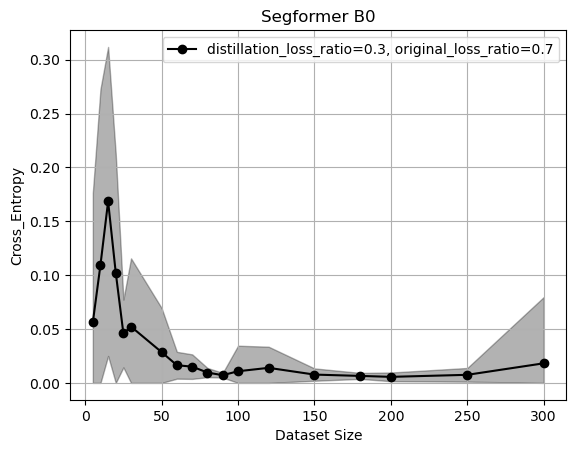

In [2]:
print("train_size size = ", np.array(train_sizes).size)
print("mean_val_losses size = ", np.array(mean_val_losses).size)
print("std_val_losses size = ", np.array(std_val_losses).size)
print("train_size = ", train_sizes)
print("mean_val_losses = ", mean_val_losses)
print("std_val_losses = ", std_val_losses)

plt.figure()
plt.plot(train_sizes, mean_val_losses, marker='o', color='black', label=f'distillation_loss_ratio={teacher_ratio}, original_loss_ratio={round(1-teacher_ratio, 2)}')
plt.fill_between(train_sizes, np.maximum(0, np.array(mean_val_losses) - np.array(std_val_losses)), 
                 np.array(mean_val_losses) + np.array(std_val_losses), color='black', alpha=0.3)
plt.title('Segformer B0')
plt.xlabel('Dataset Size')
plt.ylabel('Cross_Entropy')
plt.grid(True)
plt.legend()
plt.show()